In [0]:
pip install --upgrade tensorflow

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import files
dataset_file_dict = files.upload()

In [3]:
! nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

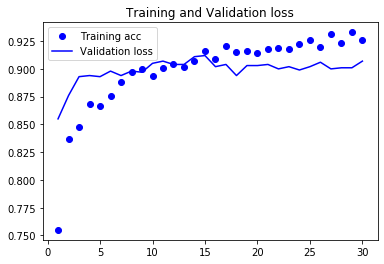

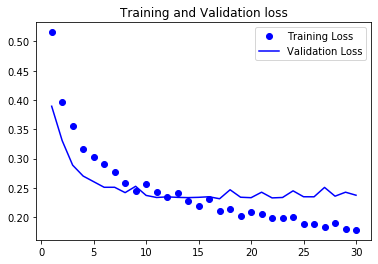

CPU times: user 9min 56s, sys: 22.2 s, total: 10min 18s
Wall time: 32min 54s


In [0]:
%%time
import tensorflow as tf
import matplotlib.pyplot as plt
import os, shutil
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))
    # weights : 모델을 초기화할 가중치 체크포인트(checkpoint)를 지정
    # include_top : 네트워크의 최상위 완전 연결 분류기를 포함할지 안 할지 지정. 기본값은 ImageNet의 클래스 1000개에 대응되는 완전
    # 연결 분류기를 포함. 별도의 (강아지와 고양이 2개의 클래스를 구분하는) 완전 연결 층을 추가하려고 하므로 이를 포함하지 않는다.
    # input_shape : 네트워크에 주입할 이미지 텐서의 크기. 이 매개변수는 선택사항. 이 값을 지정하지 않으면 네트워크가 어떤 크기의
    # 입력도 처리할 수 있다.
    
conv_base.summary()

currentPath = os.getcwd()
print(currentPath)
os.chdir('/content/drive/My Drive/Colab Notebooks/jupyter_project/')



# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = '/content/drive/My Drive/Colab Notebooks/jupyter_project/Datasets/train'

validation_dir = '/content/drive/My Drive/Colab Notebooks/jupyter_project/Datasets/validation'

test_dir = '/content/drive/My Drive/Colab Notebooks/jupyter_project/Datasets/test'


# 훈련용 고양이 사진 디렉터리
train_cats_dir = '/content/drive/My Drive/Colab Notebooks/jupyter_project/Datasets/train/cats'

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = '/content/drive/My Drive/Colab Notebooks/jupyter_project/Datasets/train/dogs'


# 검증용 고양이 사진 디렉터리
validation_cats_dir = '/content/drive/My Drive/Colab Notebooks/jupyter_project/Datasets/validation/cats'

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = '/content/drive/My Drive/Colab Notebooks/jupyter_project/Datasets/validation/dogs'

# 테스트용 고양이 사진 디렉터리
test_cats_dir = '/content/drive/My Drive/Colab Notebooks/jupyter_project/Datasets/test/cats'

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = '/content/drive/My Drive/Colab Notebooks/jupyter_project/Datasets/test/dogs'


#-------------------------------------------------------------------------------------------


# 합성곱 기반 층 위에 완전 연결 분류기 추가하기

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()

print('conv_base를 동결하기 전 훈련되는 가중치의 수:', len(model.trainable_weights))
conv_base.trainable = False

print('conv_base를 동결한 후 훈련되는 가중치의 수:', len(model.trainable_weights))
    # 추가한 2개의 Dense층 가중치만 훈련(층마다 2개씩 가중치 행렬과 편향 벡터 총 4개의 텐서)
    
#동결된 합성곱 기반 층과 함께 모델을 end-to-end로 훈련하기

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')

model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.RMSprop(lr = 2e-5),
    metrics = ['binary_accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = 50)

# 훈련의 정확도와 손실 그래프
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc,  'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()
